# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> Water Potability Prediction</b></div>

In [3]:
# Importation des bibliothèques de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Algorithmes de Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Métriques d'évaluation
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)

import warnings
warnings.filterwarnings('ignore')


In [45]:
dataset = pd.read_csv('water-dataset.csv')

In [5]:
dataset.head()

,pH,Turbidity,Chlorine,Dissolved Oxygen,Temperature,Potability
0,7.45,15.60,0.70,7.56,50,False
1,7.83,2.41,0.77,7.58,0,True
2,8.09,2.57,0.58,7.29,50,True
3,7.16,1.19,0.53,7.83,25,True
4,7.59,4.29,0.58,7.98,25,True


In [6]:
print(f" - Nombre de lignes: {dataset.shape[0]}")
print(f" - Nombre de colonnes: {dataset.shape[1]}")

 - Nombre de lignes: 5000
 - Nombre de colonnes: 6


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                5000 non-null   float64
 1   Turbidity         5000 non-null   float64
 2   Chlorine          5000 non-null   float64
 3   Dissolved Oxygen  5000 non-null   float64
 4   Temperature       5000 non-null   int64  
 5   Potability        5000 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 200.3 KB


In [8]:
dataset.describe()

,pH,Turbidity,Chlorine,Dissolved Oxygen,Temperature
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,7.565512,3.154142,0.932878,7.342220,24.735000
std,0.851572,1.772466,1.532965,1.004724,20.399461
min,6.100000,1.000000,0.500000,6.500000,0.000000
25%,7.010000,2.020000,0.630000,6.880000,0.000000
50%,7.510000,3.030000,0.750000,7.250000,25.000000
75%,8.020000,4.040000,0.880000,7.620000,50.000000
max,13.970000,19.720000,19.920000,19.940000,50.000000


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> EDA </b></div>

In [9]:
dataset.duplicated().sum()

np.int64(0)

In [10]:
missing = dataset.isnull().sum()
missing

pH                  0
Turbidity           0
Chlorine            0
Dissolved Oxygen    0
Temperature         0
Potability          0
dtype: int64

In [11]:
potability_counts = dataset['Potability'].value_counts()
print(potability_counts)

Potability
True     4615
False     385
Name: count, dtype: int64


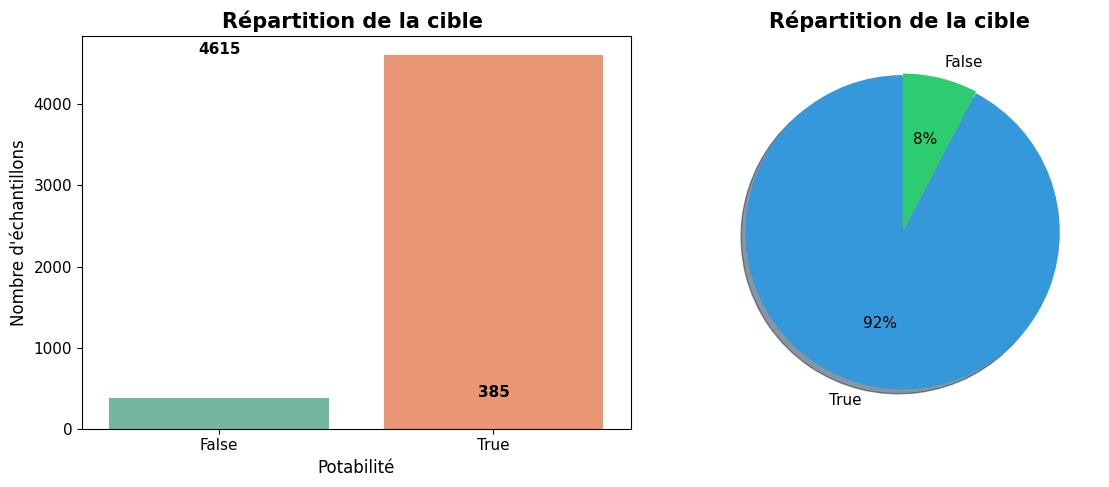

In [47]:

# Compter les occurrences de chaque classe
target = dataset['Potability'].value_counts()

# Création d'une figure avec 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ---- Bar chart ----
sns.barplot(x=target.index, y=target.values, ax=axs[0], palette="Set2")
axs[0].set_title("Répartition de la cible ", fontweight='bold')
axs[0].set_xlabel("Potabilité")
axs[0].set_ylabel("Nombre d'échantillons")
for i, v in enumerate(target.values):
    axs[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# ---- Pie chart ----
axs[1].pie(target, labels=target.index, explode=[0, 0.01],
           autopct='%.f%%', shadow=True, startangle=90, colors=['#3498db','#2ecc71'])
axs[1].set_title("Répartition de la cible ", fontweight='bold')

# Ajuster l'espacement
plt.tight_layout()

# Sauvegarder la figure
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')

# Afficher
plt.show()


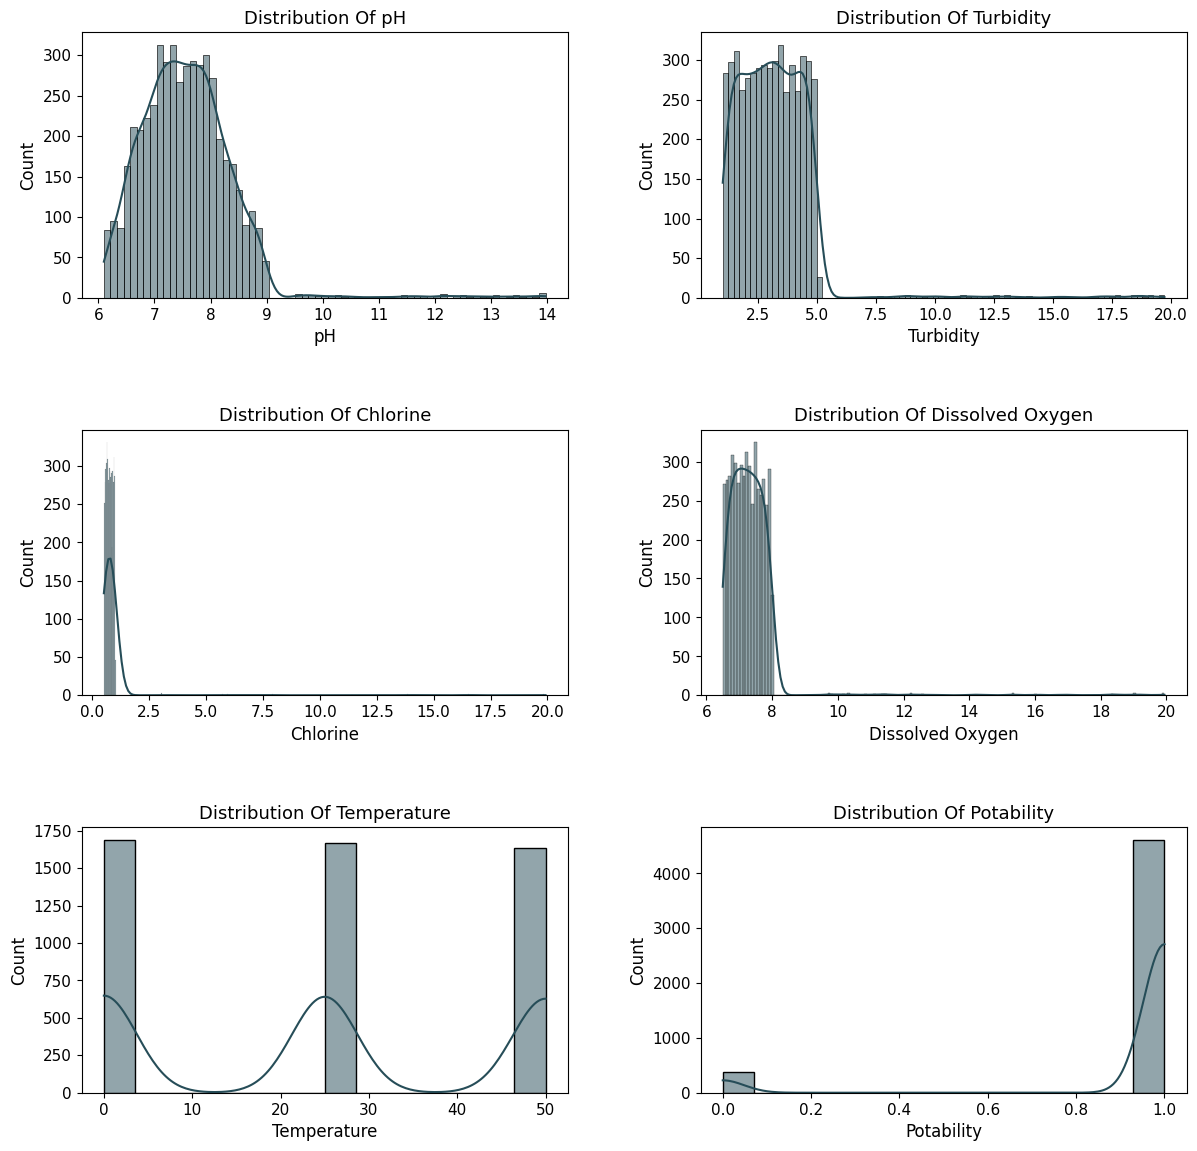

In [48]:
plt.figure(figsize=(13,20))
for k, cols in enumerate(dataset):
    plt.subplot(5,2, k+1)
    sns.histplot(x=cols,data=dataset, color='#264D58', kde=True)
    plt.title(f"Distribution Of {cols}", fontsize=13)
    plt.tight_layout(pad=4.0)
plt.savefig('distribution.png', dpi=300, bbox_inches='tight')    
plt.show()

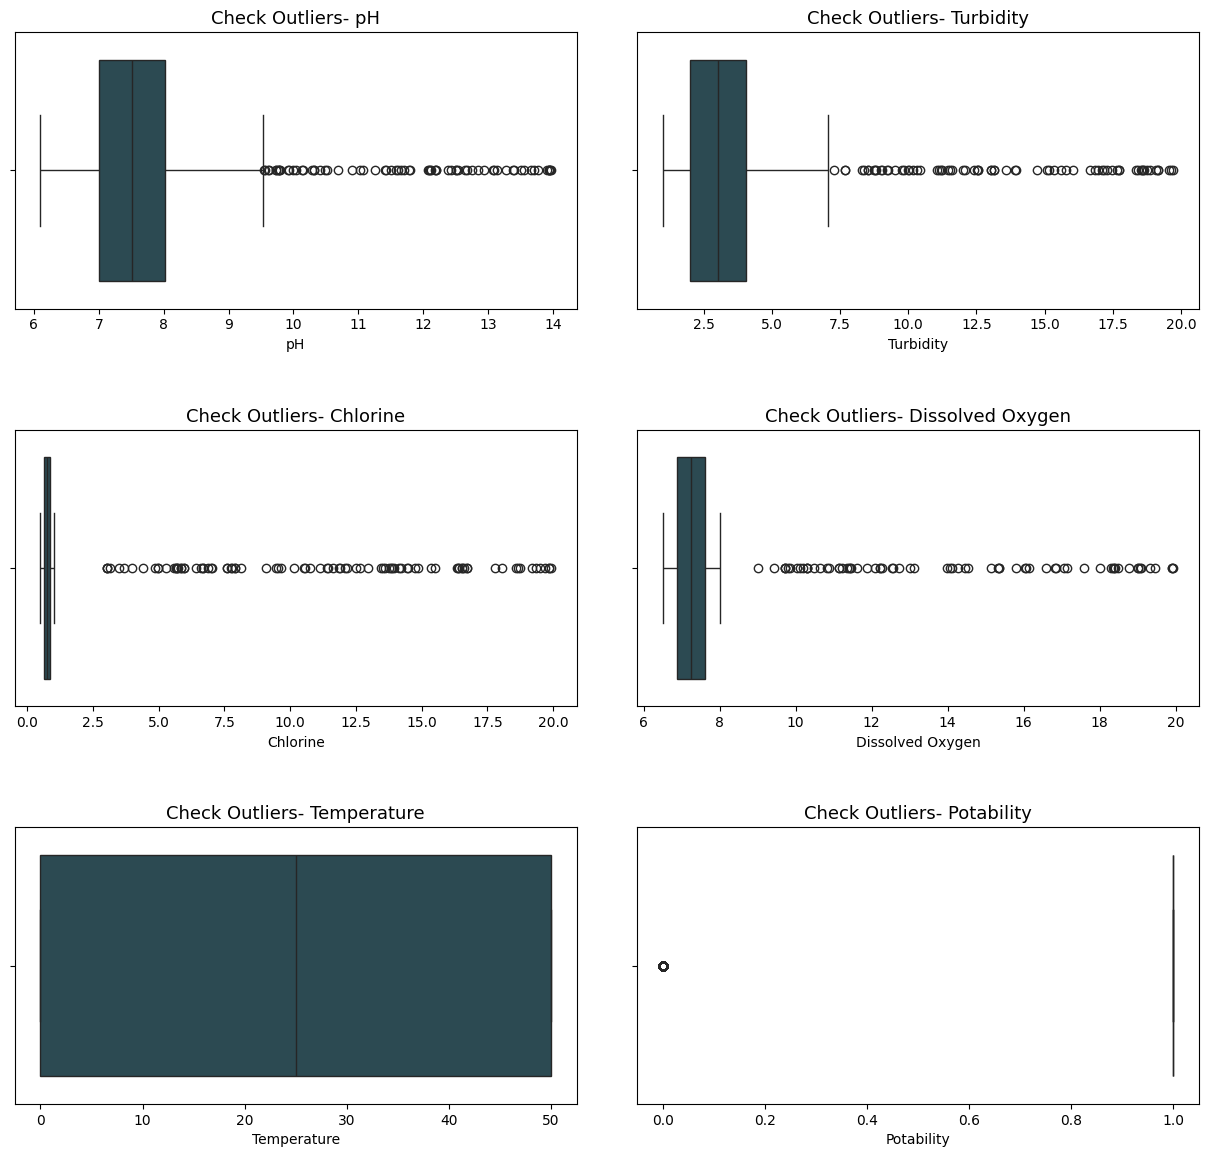

In [14]:
plt.figure(figsize=(13,20))
for k, cols in enumerate(dataset):
    plt.subplot(5,2, k+1)
    sns.boxplot(x=cols,data=dataset, color='#264D58')
    plt.title(f"Check Outliers- {cols}", fontsize=13)
    plt.tight_layout(pad=4.0)
    
plt.show()

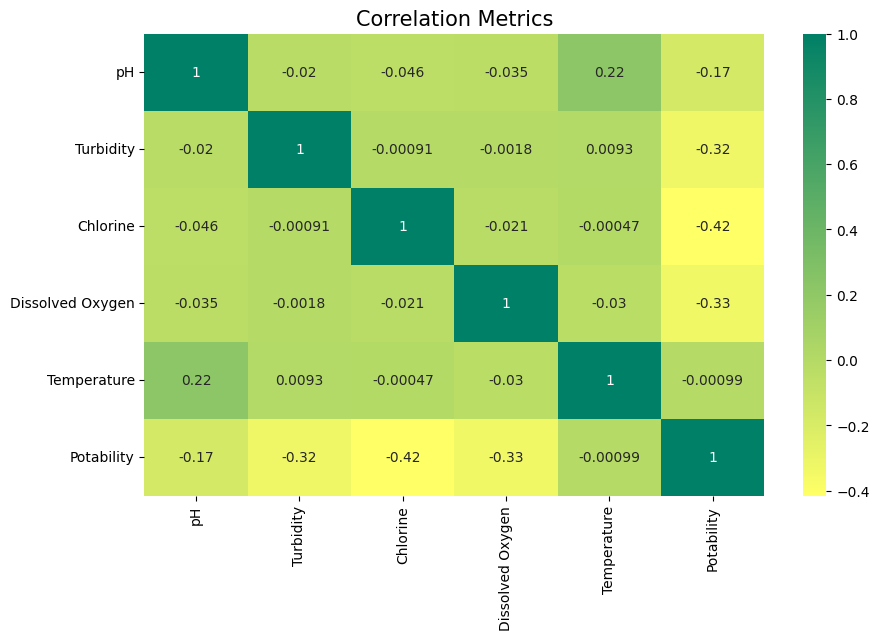

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(dataset.corr(), annot=True, cmap='summer_r')
plt.title('Correlation Metrics', fontsize=15)
plt.show()

In [16]:
# Convertir en numérique (1=Potable, 0=Non-Potable)
dataset['Potability_numeric'] = dataset['Potability'].astype(int)

In [17]:
features = ['pH', 'Turbidity', 'Chlorine', 'Dissolved Oxygen', 'Temperature']
X = dataset[features]
y = dataset['Potability_numeric']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, 
                                                      stratify=y)

In [19]:
from collections import Counter
print(f"   Train: {X_train.shape[0]} ({Counter(y_train)[1]} potable, {Counter(y_train)[0]} non-potable)")
print(f"   Test:  {X_test.shape[0]} ({Counter(y_test)[1]} potable, {Counter(y_test)[0]} non-potable)")


   Train: 4000 (3692 potable, 308 non-potable)
   Test:  1000 (923 potable, 77 non-potable)


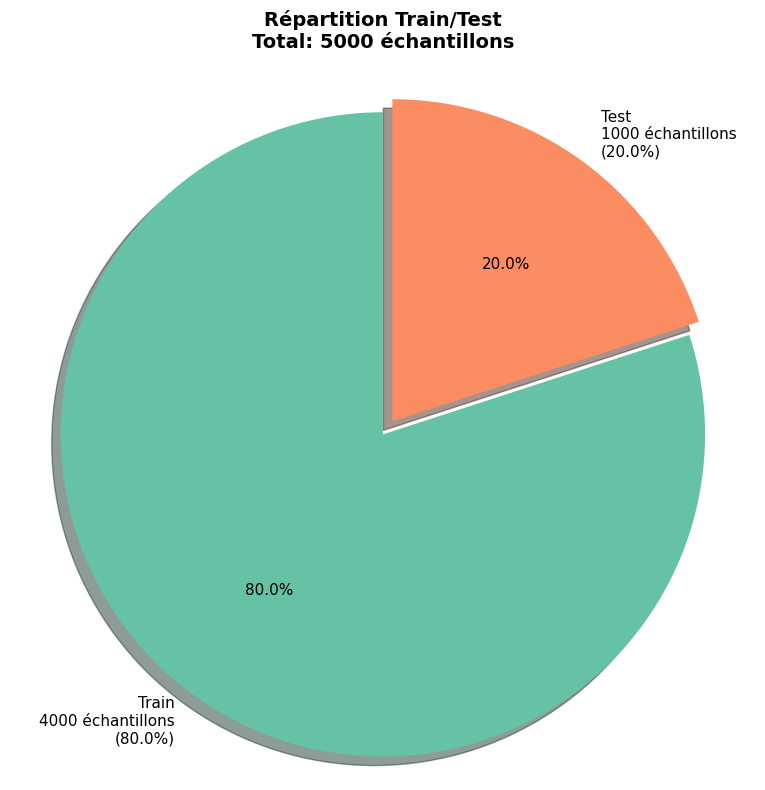

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Calculer les tailles
train_size = len(X_train)
test_size = len(X_test)
total_size = train_size + test_size

# Calculer les pourcentages
train_pct = (train_size / total_size) * 100
test_pct = (test_size / total_size) * 100

# Créer le diagramme circulaire
plt.figure(figsize=(8, 8))
sizes = [train_pct, test_pct]
labels = [f'Train\n{train_size} échantillons\n({train_pct:.1f}%)', 
          f'Test\n{test_size} échantillons\n({test_pct:.1f}%)']
colors = ['#66c2a5', '#fc8d62']
explode = (0.05, 0)  # Détacher légèrement le premier segment

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90, shadow=True,
        textprops={'fontsize': 11})

plt.title(f'Répartition Train/Test\nTotal: {total_size} échantillons', 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')  # Assure que le pie chart est un cercle
plt.tight_layout()
plt.savefig('repartition_train_test.png', dpi=300, bbox_inches='tight')
plt.show()



# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Scaling Data </b></div>

In [ ]:
# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

   - X_train_scaled: (4000, 5)
   - X_test_scaled: (1000, 5)


In [22]:
# Convertir en DataFrame pour affichage
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

In [23]:
print(f"\n Statistiques APRÈS normalisation (X_train_scaled):")
print(X_train_scaled_df.describe().round(2))


 Statistiques APRÈS normalisation (X_train_scaled):
            pH  Turbidity  Chlorine  Dissolved Oxygen  Temperature
count  4000.00    4000.00   4000.00           4000.00      4000.00
mean     -0.00      -0.00      0.00              0.00         0.00
std       1.00       1.00      1.00              1.00         1.00
min      -1.75      -1.19     -0.28             -0.83        -1.21
25%      -0.65      -0.62     -0.19             -0.46        -1.21
50%      -0.05      -0.07     -0.12             -0.10         0.01
75%       0.55       0.47     -0.03              0.28         1.23
max       7.67       9.03     12.43             12.47         1.23


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Models Building</b></div>

In [24]:
from imblearn.over_sampling import SMOTE

# Appliquer SMOTE sur l'ensemble d'entraînement
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_scaled, y_train)

print("Avant : ", Counter(y_train))
print("Après  : ", Counter(y_train_balanced))


Avant :  Counter({1: 3692, 0: 308})
Après  :  Counter({1: 3692, 0: 3692})


In [25]:
# Entraînement des modèles de classification
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators = 200, criterion = 'entropy' ,   random_state = 0),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}



💦 Model Name: Logistic Regression
Accuracy Score: 0.92
Precision Score: 0.7419442266554384
__________________________________________________



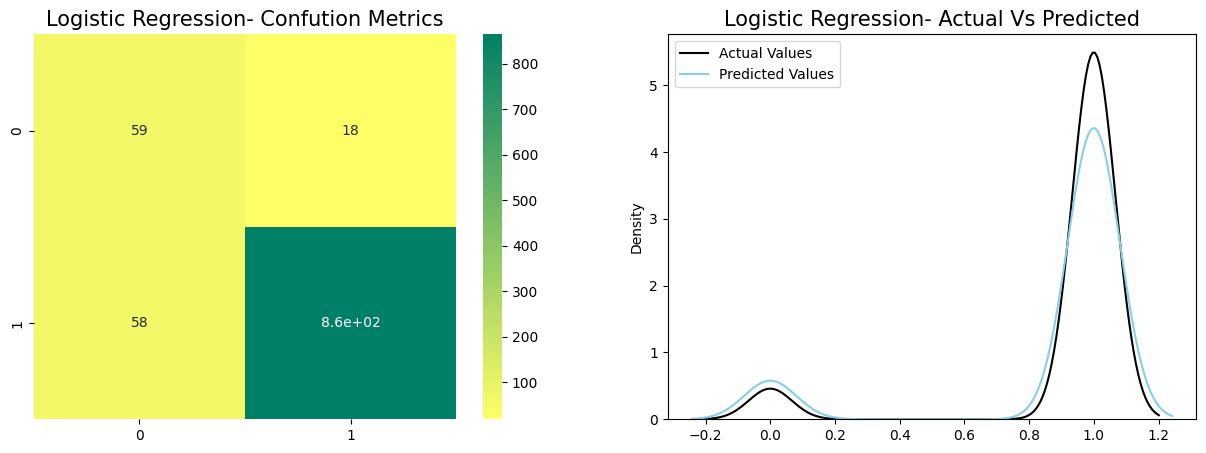


💦 Model Name: Random Forest
Accuracy Score: 0.97
Precision Score: 0.9035228533068707
__________________________________________________



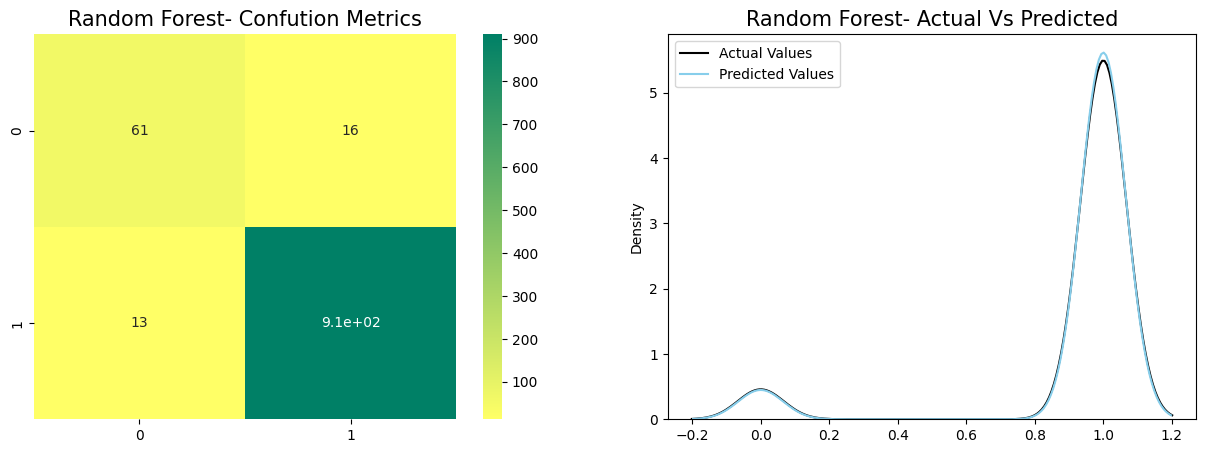


💦 Model Name: SVM
Accuracy Score: 0.98
Precision Score: 0.9914802981895634
__________________________________________________



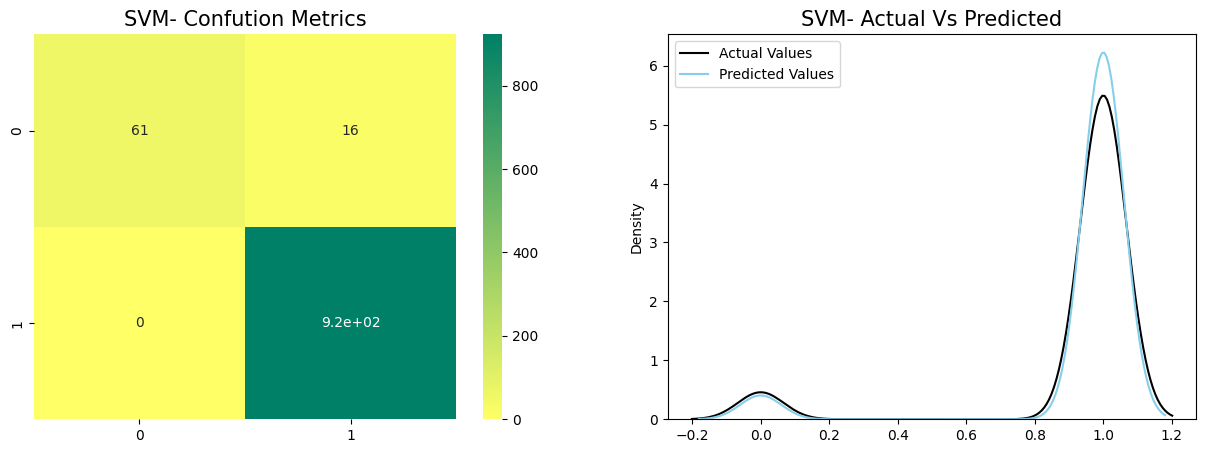


💦 Model Name: XGBoost
Accuracy Score: 0.96
Precision Score: 0.8725543478260869
__________________________________________________



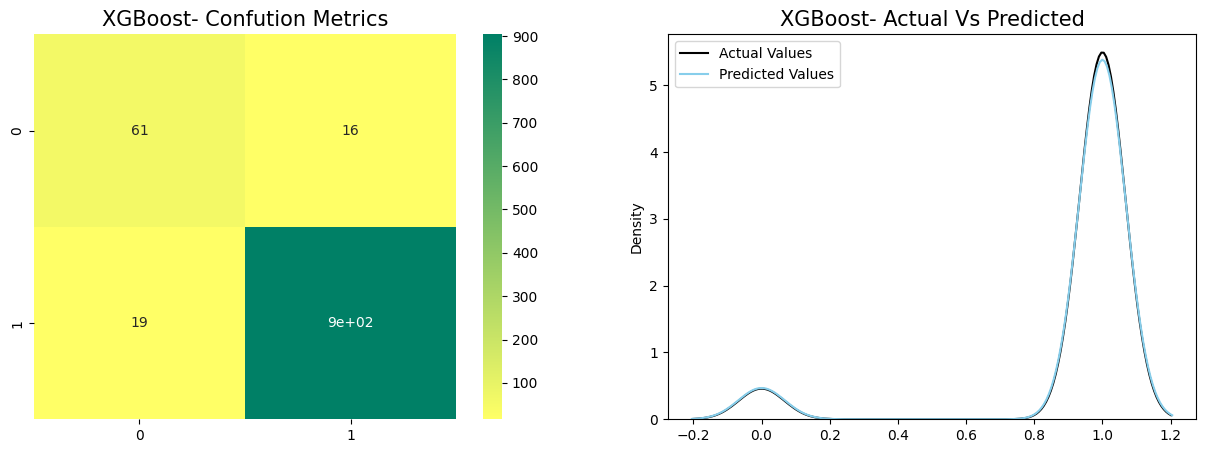

In [26]:
for m_name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_preds = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_preds)
    precision= precision_score(y_test, y_preds, average='macro')
    
    print(f'\n💦 Model Name: {m_name}')
    print(f'Accuracy Score: {accuracy:.2f}')
    print(f'Precision Score: {precision}')
    print('_' * 50)
    print()
    
    cm = confusion_matrix(y_test, y_preds)
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, cmap='summer_r')
    plt.title(f'{m_name}- Confution Metrics', fontsize=15)
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(y_test.values, color='black', label='Actual Values')
    sns.kdeplot(y_preds, color='skyblue',label='Predicted Values')
    plt.title(f'{m_name}- Actual Vs Predicted', fontsize=15)
    plt.legend()
    plt.show()

In [27]:
# Dictionnaire pour stocker les résultats
results = {}
# Entraîner chaque modèle
for name, model in models.items():
    print(f"\n⏳ Entraînement de {name}...")
    
    # Entraîner le modèle
    model.fit(X_train_balanced, y_train_balanced)
    
    # Prédictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Stocker les résultats
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred
    }
    print(f"      - Accuracy: {accuracy:.4f}")
    print(f"      - Precision: {precision:.4f}")
    print(f"      - Recall: {recall:.4f}")
    print(f"      - F1-Score: {f1:.4f}")



⏳ Entraînement de Logistic Regression...
      - Accuracy: 0.9240
      - Precision: 0.9796
      - Recall: 0.9372
      - F1-Score: 0.9579

⏳ Entraînement de Random Forest...
      - Accuracy: 0.9710
      - Precision: 0.9827
      - Recall: 0.9859
      - F1-Score: 0.9843

⏳ Entraînement de SVM...
      - Accuracy: 0.9840
      - Precision: 0.9830
      - Recall: 1.0000
      - F1-Score: 0.9914

⏳ Entraînement de XGBoost...
      - Accuracy: 0.9650
      - Precision: 0.9826
      - Recall: 0.9794
      - F1-Score: 0.9810


In [28]:
# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()]
})

In [29]:
# Trier par F1-Score
results_df = results_df.sort_values('F1-Score', ascending=False)

print("📊 Tableau de comparaison des modèles:")
print(results_df.to_string(index=False))

📊 Tableau de comparaison des modèles:
              Model  Accuracy  Precision   Recall  F1-Score
                SVM     0.984   0.982961 1.000000  0.991407
      Random Forest     0.971   0.982721 0.985915  0.984316
            XGBoost     0.965   0.982609 0.979415  0.981009
Logistic Regression     0.924   0.979615 0.937161  0.957918


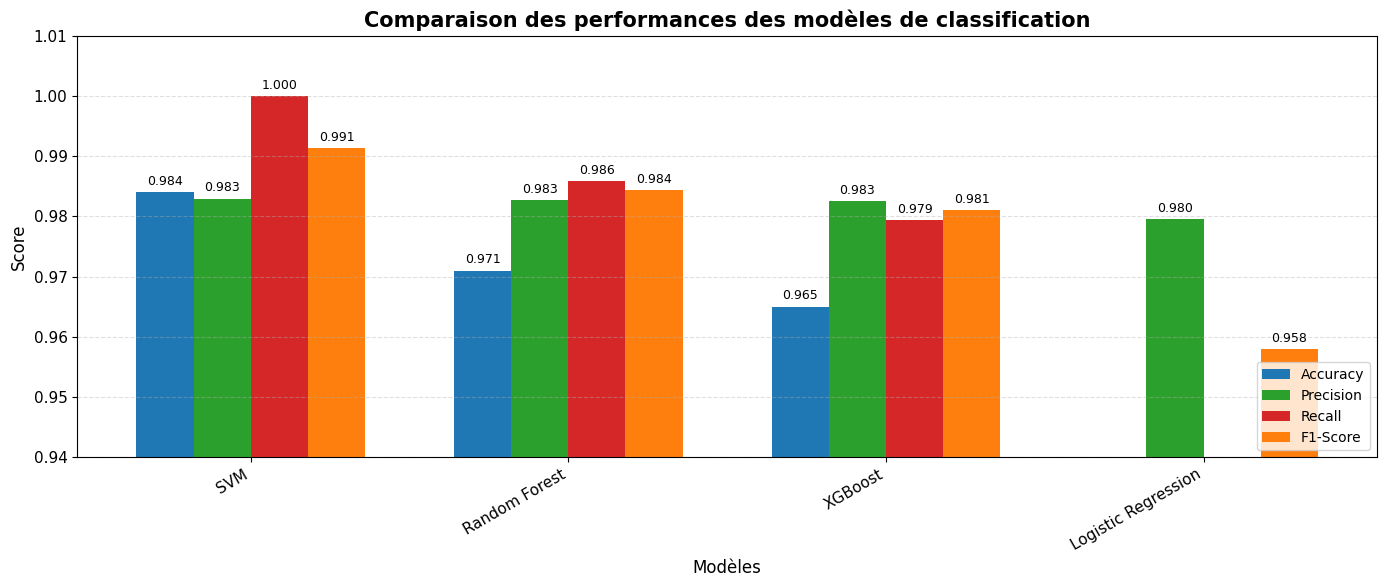

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration globale (style académique)
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "legend.fontsize": 10
})

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(results_df))
width = 0.18

bars_acc = ax.bar(x - 1.5*width, results_df['Accuracy'], width,
                  label='Accuracy', color='#1f77b4')
bars_pre = ax.bar(x - 0.5*width, results_df['Precision'], width,
                  label='Precision', color='#2ca02c')
bars_rec = ax.bar(x + 0.5*width, results_df['Recall'], width,
                  label='Recall', color='#d62728')
bars_f1  = ax.bar(x + 1.5*width, results_df['F1-Score'], width,
                  label='F1-Score', color='#ff7f0e')

# Titres et labels
ax.set_title("Comparaison des performances des modèles de classification",
             fontweight='bold')
ax.set_xlabel("Modèles")
ax.set_ylabel("Score")

ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=30, ha='right')

# Limites et grille
ax.set_ylim(0.94, 1.01)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Légende
ax.legend(loc='lower right', frameon=True)

# Annotation des valeurs
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

for bars in [bars_acc, bars_pre, bars_rec, bars_f1]:
    annotate_bars(bars)

plt.tight_layout()
plt.show()


In [31]:
best_model_name = results_df.iloc[0, 0]
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")


Best Model: SVM


Analyse de Random Forest...
   Random Forest:
      - Score d'entraînement final: 1.0000
      - Score de validation final: 0.9915
      - Écart (gap): 0.0085
      - Diagnostic: ✅ Bon équilibre

Analyse de XGBoost...
   XGBoost:
      - Score d'entraînement final: 0.9999
      - Score de validation final: 0.9898
      - Écart (gap): 0.0101
      - Diagnostic: ✅ Bon équilibre

Analyse de SVM...
   SVM:
      - Score d'entraînement final: 0.9914
      - Score de validation final: 0.9913
      - Écart (gap): 0.0001
      - Diagnostic: ✅ Bon équilibre

Analyse de Logistic Regression...
   Logistic Regression:
      - Score d'entraînement final: 0.9847
      - Score de validation final: 0.9845
      - Écart (gap): 0.0002
      - Diagnostic: ✅ Bon équilibre



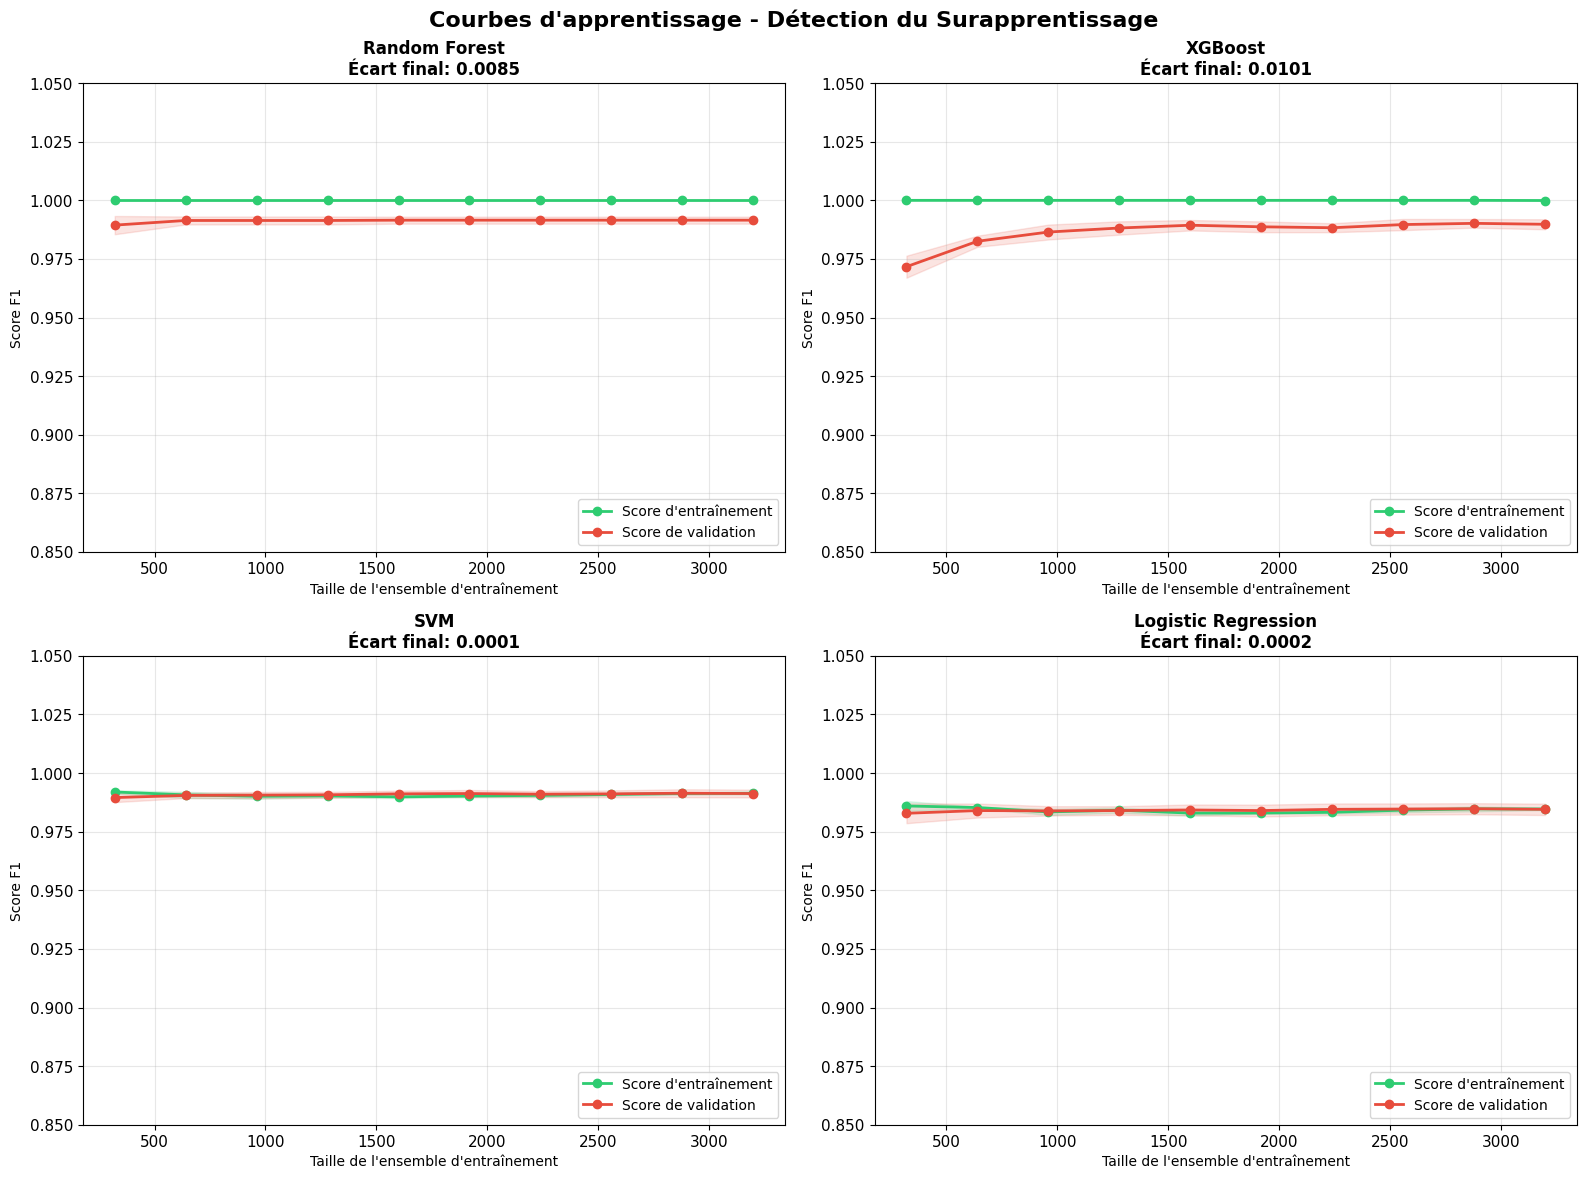

In [32]:
from sklearn.model_selection import learning_curve

# Fonction pour tracer les courbes d'apprentissage
def plot_learning_curve(model, model_name, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, 
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )
    
    # Calculer les moyennes et écarts-types
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    return train_sizes, train_mean, train_std, val_mean, val_std

# Sélectionner les 4 meilleurs modèles à analyser
models_to_analyze = ['Random Forest', 'XGBoost', 'SVM', 'Logistic Regression']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Courbes d\'apprentissage - Détection du Surapprentissage', 
             fontsize=16, fontweight='bold')

axes = axes.ravel()

for idx, model_name in enumerate(models_to_analyze):
    print(f"Analyse de {model_name}...")
    
    model = results[model_name]['model']
    
    # Générer les courbes d'apprentissage
    train_sizes, train_mean, train_std, val_mean, val_std = plot_learning_curve(
        model, model_name, X_train_scaled, y_train
    )
    # Tracer les courbes
    axes[idx].plot(train_sizes, train_mean, 'o-', color='#2ecc71', 
                   label='Score d\'entraînement', linewidth=2, markersize=6)
    axes[idx].fill_between(train_sizes, train_mean - train_std, 
                           train_mean + train_std, alpha=0.15, color='#2ecc71')
    
    axes[idx].plot(train_sizes, val_mean, 'o-', color='#e74c3c', 
                   label='Score de validation', linewidth=2, markersize=6)
    axes[idx].fill_between(train_sizes, val_mean - val_std, 
                           val_mean + val_std, alpha=0.15, color='#e74c3c')
    
    # Calculer l'écart (gap) entre train et validation
    gap = train_mean[-1] - val_mean[-1]
    
    axes[idx].set_title(f'{model_name}\nÉcart final: {gap:.4f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Taille de l\'ensemble d\'entraînement', fontsize=10)
    axes[idx].set_ylabel('Score F1', fontsize=10)
    axes[idx].legend(loc='lower right')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_ylim([0.85, 1.05])
    
    # Diagnostic du surapprentissage
    if gap > 0.05:
        status = "⚠️ Surapprentissage détecté"
        color = "red"
    elif gap > 0.02:
        status = "⚡ Léger surapprentissage"
        color = "orange"
    else:
        status = "✅ Bon équilibre"
        color = "green"
    
    print(f"   {model_name}:")
    print(f"      - Score d'entraînement final: {train_mean[-1]:.4f}")
    print(f"      - Score de validation final: {val_mean[-1]:.4f}")
    print(f"      - Écart (gap): {gap:.4f}")
    print(f"      - Diagnostic: {status}\n")

plt.tight_layout()
plt.show()


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> Evalution </b></div>

In [33]:
# Prédictions sur le jeu de test normalisé
y_pred_best = best_model.predict(X_test_scaled)

# Rapport complet
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_best))



Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        77
           1       0.98      1.00      0.99       923

    accuracy                           0.98      1000
   macro avg       0.99      0.90      0.94      1000
weighted avg       0.98      0.98      0.98      1000



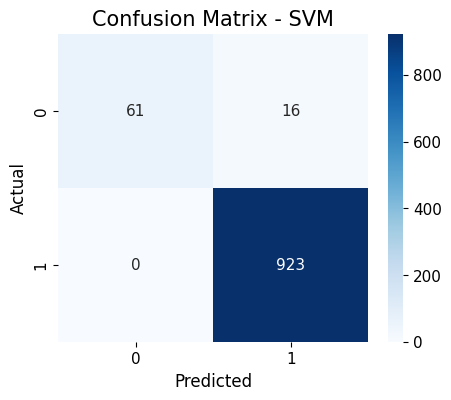

In [34]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:

# Cross-validation 
cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")



Cross-Validation Accuracy: 89.68% ± 0.61%


In [36]:
from sklearn.svm import SVC

svm_final = SVC(
    kernel='rbf',
    probability=True,
    random_state=42
)

svm_final.fit(X_train_balanced, y_train_balanced)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [37]:
y_test_pred = svm_final.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix

print("📊 Évaluation finale du modèle SVM\n")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
print("Matrice de confusion :\n", cm)


📊 Évaluation finale du modèle SVM

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        77
           1       0.98      1.00      0.99       923

    accuracy                           0.98      1000
   macro avg       0.99      0.90      0.94      1000
weighted avg       0.98      0.98      0.98      1000

Matrice de confusion :
 [[ 61  16]
 [  0 923]]


In [42]:
import numpy as np

nouvelle_eau = np.array([[7.5, 18, 0.7, 7.5, 50]])  
# [pH, Turbidity, Chlorine, Dissolved Oxygen, Temperature]


In [43]:
nouvelle_eau_scaled = scaler.transform(nouvelle_eau)


In [44]:
prediction = svm_final.predict(nouvelle_eau_scaled)
proba = svm_final.predict_proba(nouvelle_eau_scaled)

if prediction[0] == 1:
    print("✅ Eau POTABLE")
else:
    print("❌ Eau NON POTABLE")

print(f"Probabilité eau potable : {proba[0][1]*100:.2f}%")


❌ Eau NON POTABLE
Probabilité eau potable : 0.00%


In [49]:
import joblib

# Sauvegarde
joblib.dump(svm_final, "svm_potabilite_model.pkl")
joblib.dump(scaler, "scaler_potabilite.pkl")

print("✅ Modèle SVM et scaler sauvegardés avec succès")


✅ Modèle SVM et scaler sauvegardés avec succès
